# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
Repaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя
Целевой признак
Price — цена (евро)

## Подготовка данных

In [1]:
#подключим необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
#загрузим данные
df = pd.read_csv('/datasets/autos.csv')

In [3]:
#посмотрим первые пять строк датасета
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
#выведим наименования колонок 
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [5]:
#посмотрим общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
#поиск явных дубликатов
df.duplicated().sum()

4

In [7]:
#удалим дубликаты
df=df.drop_duplicates()

In [8]:
#проверим
df.duplicated().sum()

0

In [9]:
#посмотрим сколько суммарно имеется прощенных значений по каждому столбцу
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [10]:
#заполним пропущенные значения в столбце 'VehicleType' на 'other'
df['VehicleType'].fillna('other',inplace=True)


In [11]:
#заполним пропущенные значения в столбце 'Gearbox' на наиболее часто встречающееся
df['Gearbox']=df['Gearbox'].fillna(df['Gearbox'].mode()[0])

In [12]:
#заполним пропущенные значения в столбце 'Model' на 'unknown'
df['Model'].fillna('unknown',inplace=True)

In [13]:
#посмотрим значения в столбце 'FuelType'
df['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [14]:
#заполним пропущенные значения в столбце 'FuelType' на 'other'
df['FuelType'].fillna('other',inplace=True)

In [15]:
#заполним пропущенные значения в столбце 'Repaired' на наиболее часто встречающееся
df['Repaired']=df['Repaired'].fillna(df['Repaired'].mode()[0])

In [16]:
#удалим столбецы с данными, которые в дальнейшем нам не понядобяться
df=df.drop(columns=['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'])

In [17]:
#посмотрим изменения
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [18]:
df.shape

(354365, 10)

Найдем и обработаем аномалии

In [19]:
#посмотрим значения в столбце 'VehicleType '
df['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
other          40778
bus            28775
convertible    20203
coupe          16161
suv            11996
Name: VehicleType, dtype: int64

В столбце 'VehicleType' аномалии не обнаружены.

In [20]:
#посмотрим значения в столбце 'RegistrationYear'
df['RegistrationYear'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [21]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Мы видим Год регистрации имеются аномальные значения и значения не соответствующие году. 

Так же не вижу смысла брать данные по старым годам (до 1990 года), так как ценообразование на автомобили могло изменится, поэтому возьмем для анализа данные с 1990 года по 2016 год.

In [22]:
df=df.loc[df['RegistrationYear'] >= 1990]

In [23]:
df=df.loc[df['RegistrationYear'] <= 2016]

In [24]:
#посмотрим полученные значения в столбце 'RegistrationYear'
df['RegistrationYear'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
2003    19762
2004    19611
2002    19091
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
2015     1302
Name: RegistrationYear, dtype: int64

In [25]:
df.shape

(330166, 10)

In [26]:
#посмотрим значения в столбце 'Gearbox '
df['Gearbox'].value_counts()

manual    267721
auto       62445
Name: Gearbox, dtype: int64

В столбце 'Gearbox' аномалии не обнаружены.

In [27]:
#посмотрим значения в столбце 'Brand'
df['Brand'].value_counts()

volkswagen        70886
opel              37334
bmw               35074
mercedes_benz     29388
audi              27974
ford              23671
renault           16805
peugeot           10577
fiat               8852
seat               6528
mazda              5352
skoda              5332
smart              5029
citroen            4763
nissan             4698
toyota             4395
hyundai            3446
mini               3064
volvo              3023
mitsubishi         2881
honda              2639
kia                2362
sonstige_autos     2273
suzuki             2174
alfa_romeo         2130
chevrolet          1489
chrysler           1352
dacia               873
daihatsu            773
subaru              728
jeep                599
porsche             574
daewoo              512
land_rover          493
saab                488
jaguar              457
rover               451
lancia              418
lada                178
trabant             131
Name: Brand, dtype: int64

В столбце 'Brand' аномалии не обнаружены.

In [28]:
#посмотрим значения в столбце 'Repaired'
df['Repaired'].value_counts() 

no     296272
yes     33894
Name: Repaired, dtype: int64

В столбце 'Repaired' аномалии не обнаружены.

<AxesSubplot:xlabel='Kilometer'>

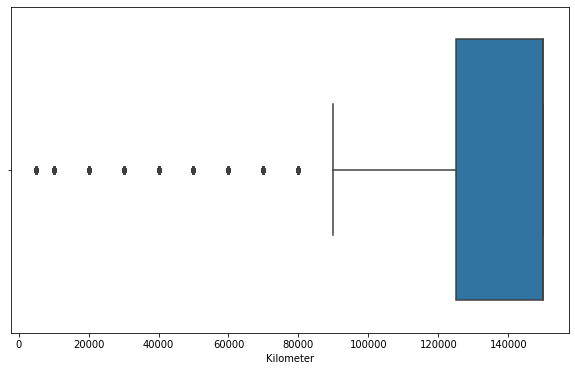

In [29]:
#посмотрим на аномалии по столбцу 'Kilometer'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Kilometer'])


Аномально больших значений не имеется, есть значения менее 80 000 км, но удалять их не стоит, потому что просто автомобили с небольшим пробегом.

<AxesSubplot:xlabel='Power'>

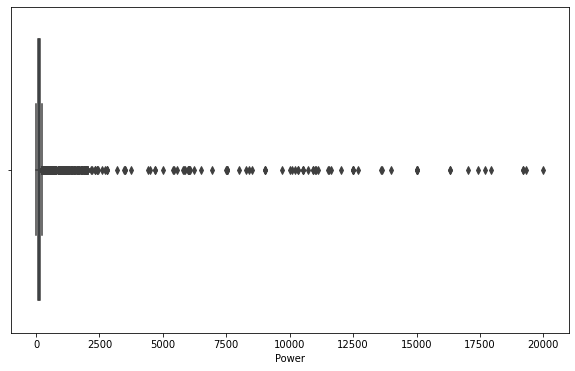

In [30]:
#посмотрим на аномалии по столбцу 'Power'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Power'])

In [31]:
print(df.loc[df['Power'] >= 1000])

        Price VehicleType  RegistrationYear Gearbox  Power    Model  \
1816     3200       small              2004  manual   1398  corolla   
2102        0       sedan              1999  manual   1799   vectra   
5328      500       wagon              1999  manual   1001    astra   
7661     1499       small              1999  manual   7515     lupo   
7720     1500       small              2000  manual   1400  unknown   
...       ...         ...               ...     ...    ...      ...   
348668   1000       wagon              1996  manual   2598       a6   
348883   7500       sedan              2011  manual   1548   scenic   
348968    250       small              1999  manual   1241  ypsilon   
351947   1500         bus              2001  manual   1001   zafira   
354260    399       other              1994  manual   1103      3er   

        Kilometer  FuelType       Brand Repaired  
1816         5000    petrol      toyota       no  
2102       150000    petrol        opel      

In [32]:
df.shape

(330166, 10)

In [33]:
df=df.loc[df['Power'] <= 1000]

In [34]:
df.shape

(329897, 10)

In [35]:
print(df.loc[df['Power'] <= 5])

        Price VehicleType  RegistrationYear Gearbox  Power     Model  \
0         480       other              1993  manual      0      golf   
32        245       sedan              1994  manual      0      golf   
37       1500       other              2016  manual      0    kangoo   
40          0       other              1990  manual      0     corsa   
54       4700       wagon              2005  manual      0    signum   
...       ...         ...               ...     ...    ...       ...   
354346   2600       other              2005    auto      0  c_klasse   
354360   3999       wagon              2005  manual      3       3er   
354363   1150         bus              2000  manual      0    zafira   
354364      0       other              2005  manual      0      colt   
354365   2200       other              2005  manual      0   unknown   

        Kilometer  FuelType           Brand Repaired  
0          150000    petrol      volkswagen       no  
32         150000    petr

In [36]:
df=df.loc[df['Power'] >= 5]

In [37]:
df.shape

(295704, 10)

Ограничем мощность от 100 до 1000 единиц

<AxesSubplot:xlabel='Price'>

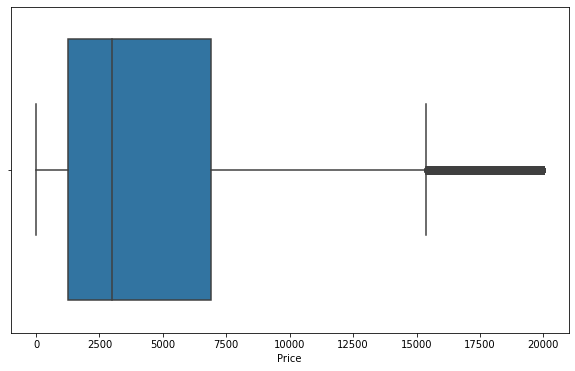

In [38]:
#посмотрим на аномалии по столбцу 'Price'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])

In [39]:
print(df.loc[df['Price'] <= 100])

        Price VehicleType  RegistrationYear Gearbox  Power     Model  \
59          1         suv              1994  manual    286   unknown   
89          1       sedan              1995  manual    113  e_klasse   
152         0         bus              2004  manual    101    meriva   
231         0       wagon              2001  manual    115    mondeo   
268         1       sedan              1990  manual     90        80   
...       ...         ...               ...     ...    ...       ...   
354205      0       other              2000  manual     65     corsa   
354238      0       small              2002  manual     60    fiesta   
354248      0       small              1999  manual     53     swift   
354277      0       small              1999  manual     37     arosa   
354309     99       small              1999  manual     60     arosa   

        Kilometer  FuelType           Brand Repaired  
59         150000     other  sonstige_autos       no  
89         150000  gasoli

In [40]:
df=df.loc[df['Price'] >= 100]

In [41]:
df.shape

(288491, 10)

Вывод

Датасет загружен

Проведена предобработка данных

Форматы данных корректные

Найдены и удалены дубликаты

Заполнены пропущенные значения

Удалены неинформативные столбцы

Аномалии найдены и обработаны

Размер преобразованной таблицы составил 10 столбцов и 354 365 строк.




## Обучение моделей

In [42]:
#подготовим выборки для обучения моделей
#признаками будут являться все, кроме 'Price',поэтому удалим этот столбец
features = df.drop(['Price'], axis=1)
#целевой признак - 'Price',выберем его
target = df['Price']

#отделим 40% данных для валидационной и тестовой выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345) 

In [43]:
#размер тренировочной выборки
features_train.shape

(173094, 9)

In [44]:
#размер валидационной и тестовой выборки
features_valid_test.shape

(115397, 9)

In [45]:
#отделим пополам данные валидационной и тестовой выборки
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [46]:
#размер тестовой выборки
features_test.shape

(57698, 9)

In [47]:
#размер валидационной выборки
features_valid.shape

(57699, 9)

In [48]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])



Catboost

In [49]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [50]:
cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

In [51]:
%%time
model = CatBoostRegressor(loss_function="RMSE", iterations=150)
model.fit(features_train, target_train,cat_features=cat_features, verbose=10)


Learning rate set to 0.432181
0:	learn: 3399.6580853	total: 116ms	remaining: 17.3s
10:	learn: 1808.4708262	total: 660ms	remaining: 8.33s
20:	learn: 1722.0372503	total: 1.17s	remaining: 7.18s
30:	learn: 1676.7639838	total: 1.68s	remaining: 6.45s
40:	learn: 1645.2609073	total: 2.19s	remaining: 5.83s
50:	learn: 1619.2883064	total: 2.72s	remaining: 5.28s
60:	learn: 1597.0150923	total: 3.22s	remaining: 4.7s
70:	learn: 1576.0319803	total: 3.74s	remaining: 4.16s
80:	learn: 1563.1932866	total: 4.24s	remaining: 3.61s
90:	learn: 1552.6752583	total: 4.74s	remaining: 3.07s
100:	learn: 1540.3489887	total: 5.25s	remaining: 2.55s
110:	learn: 1528.6745352	total: 5.78s	remaining: 2.03s
120:	learn: 1520.1201345	total: 6.3s	remaining: 1.51s
130:	learn: 1514.0357354	total: 6.83s	remaining: 991ms
140:	learn: 1505.9637590	total: 7.33s	remaining: 468ms
149:	learn: 1500.3926971	total: 7.79s	remaining: 0us
CPU times: user 7.98 s, sys: 115 ms, total: 8.1 s
Wall time: 8.55 s


In [52]:
%%time
predicted_valid = model.predict(features_valid)
rmse=np.sqrt(mean_squared_error(target_valid, predicted_valid))
print("RMSE:", rmse)

RMSE: 1547.3423719943892
CPU times: user 80 ms, sys: 291 µs, total: 80.3 ms
Wall time: 78.2 ms


LightGBM

Спасибо, я просто подумала что для Сatboost можно и не преобразовывать данные, так как он не жалуется на категориальные признаки.

In [55]:
model = lgb.LGBMRegressor(random_state=12345)

#задаем сетку параметров
param_grid = {
    'n_estimators': [100, 3000],
    'num_leaves': [1, 5]
}

#инициализируем GridSearchCV и обучаем на данных
grid_search = GridSearchCV(model, param_grid=param_grid, cv=3,verbose=10, n_jobs=-1)
grid_search.fit(features_train_ord, target_train)

#получаем лучшие гиперпараметры
best_params = grid_search.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START n_estimators=100, num_leaves=1..............................
[CV 1/3; 1/4] END ............n_estimators=100, num_leaves=1; total time=   0.0s
[CV 2/3; 1/4] START n_estimators=100, num_leaves=1..............................
[CV 2/3; 1/4] END ............n_estimators=100, num_leaves=1; total time=   0.0s
[CV 3/3; 1/4] START n_estimators=100, num_leaves=1..............................
[CV 3/3; 1/4] END ............n_estimators=100, num_leaves=1; total time=   0.0s
[CV 1/3; 2/4] START n_estimators=100, num_leaves=5..............................


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/conda/lib/python3.9/site-package

[CV 1/3; 2/4] END ............n_estimators=100, num_leaves=5; total time=   1.9s
[CV 2/3; 2/4] START n_estimators=100, num_leaves=5..............................
[CV 2/3; 2/4] END ............n_estimators=100, num_leaves=5; total time=   2.0s
[CV 3/3; 2/4] START n_estimators=100, num_leaves=5..............................
[CV 3/3; 2/4] END ............n_estimators=100, num_leaves=5; total time=   2.3s
[CV 1/3; 3/4] START n_estimators=3000, num_leaves=1.............................
[CV 1/3; 3/4] END ...........n_estimators=3000, num_leaves=1; total time=   0.0s
[CV 2/3; 3/4] START n_estimators=3000, num_leaves=1.............................
[CV 2/3; 3/4] END ...........n_estimators=3000, num_leaves=1; total time=   0.0s
[CV 3/3; 3/4] START n_estimators=3000, num_leaves=1.............................
[CV 3/3; 3/4] END ...........n_estimators=3000, num_leaves=1; total time=   0.0s
[CV 1/3; 4/4] START n_estimators=3000, num_leaves=5.............................


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/conda/lib/python3.9/site-package

[CV 1/3; 4/4] END ...........n_estimators=3000, num_leaves=5; total time= 1.2min
[CV 2/3; 4/4] START n_estimators=3000, num_leaves=5.............................
[CV 2/3; 4/4] END ...........n_estimators=3000, num_leaves=5; total time=  43.7s
[CV 3/3; 4/4] START n_estimators=3000, num_leaves=5.............................
[CV 3/3; 4/4] END ...........n_estimators=3000, num_leaves=5; total time=  43.6s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.83633997        nan 0.88868928]
  warnings.warn(


In [56]:
print(best_params)

{'n_estimators': 3000, 'num_leaves': 5}


In [62]:
%%time
model_lgb=lgb.LGBMRegressor(random_state=12345,
                          n_estimators=3000,
                          num_leaves=5)
model_lgb.fit(features_train_ord, target_train)


CPU times: user 58.9 s, sys: 119 ms, total: 59 s
Wall time: 59 s


LGBMRegressor(n_estimators=3000, num_leaves=5, random_state=12345)

In [63]:
%%time
predicted_valid = model_lgb.predict(features_valid_ord)
rmse=np.sqrt(mean_squared_error(target_valid, predicted_valid))
print("RMSE:", rmse)

RMSE: 1542.688359127059
CPU times: user 9.39 s, sys: 0 ns, total: 9.39 s
Wall time: 9.41 s


Линейная регрессия

In [64]:
%%time
model = LinearRegression()
model.fit(features_train_ord, target_train)

CPU times: user 37.5 ms, sys: 7.75 ms, total: 45.3 ms
Wall time: 91.2 ms


LinearRegression()

In [65]:
%%time
predicted_valid = model.predict(features_valid_ord)
rmse=np.sqrt(mean_squared_error(target_valid, predicted_valid))
print("RMSE:", rmse)

RMSE: 2705.316190354236
CPU times: user 9.2 ms, sys: 6.94 ms, total: 16.1 ms
Wall time: 4.5 ms


Вывод

Обучены три модели : Catboost, LightGBM и линейная регрессия.

Быстрее всех обучается - Сatboost

Медленее - LightGBM

Быстрее всех делает предстаказания - Лин6ейная регрессия

Медленее - Catboost

Наилучшие результаты по качеству модели имеет LightGBM (1613)

Наихудший линейная регрессия (2662)

## Анализ моделей

| Модель | Время обучения | Время предсказания | RMSE |
|:-----------:|:-----------:|:-----------:|:-----------:|
|    CatBoost  |    9.28 s  |    79.4ms   |    1547.3  |
|    LightGBM  |    59 s|    9.41 s   |    1542   |
|    LinearRegression |    97.2 ms   |    79.1 ms   |    2705.3  |


## Тестирование лучшей модели

        Проведем анализ на наилучшей модели - LightGBM

In [66]:
predicted_test = model_lgb.predict(features_test_ord)
rmse=np.sqrt(mean_squared_error(target_test, predicted_test))
print("RMSE:", rmse)

RMSE: 1560.0198099281142


Вывод

RMSE на тестовых данных составило 1560

Общий вывод

Датасет загружен

Проведена предобработка данных

Форматы данных корректные

Найдены и удалены дубликаты

Заполнены пропущенные значения

Удалены неинформативные столбцы

Аномалии найдены и обработаны

Размер преобразованной таблицы составил 10 столбцов и 354 365 строк.

Обучены три модели : Catboost, LightGBM и линейная регрессия.

Наилучшие результаты по качеству модели имеет LightGBM (1542)

RMSE на тестовых данных составило 1560